In [1]:
import cv2
import argparse
import numpy as np
from scipy import misc
from PIL import Image
from matplotlib import pyplot as plt
import keras
from keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dense, Flatten
from keras.models import Model, Sequential
from keras import regularizers
import csv

Using TensorFlow backend.


In [2]:
train_images = np.load("train_images.npy")
test_images = np.load("test_images.npy")
print(train_images.shape)

(50000, 28, 28)


In [0]:
def viewImages(arr):
    for img in arr:
        two_d = (np.reshape(img, (28,28))*255).astype(np.uint8)
        plt.imshow(two_d, cmap='Greys', interpolation='nearest')
        plt.show()

def viewImage(img):
    two_d = (np.reshape(img, (28, 28))*255).astype(np.uint8)
    plt.imshow(two_d, cmap='Greys', interpolation='nearest')
    plt.show()        

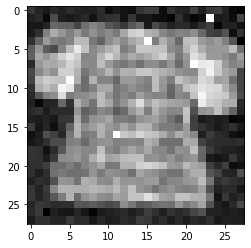

In [4]:
viewImages(train_images[:1])

In [0]:
def convolve2d(img, kernel):
  kernel = np.flipud(np.fliplr(kernel))
  output = np.zeros_like(img)

  img_padded = np.zeros((img.shape[0] + 2, img.shape[1] + 2))
  img_padded[1:-1,1:-1] = img

  for x in range(img.shape[1]):
    for y in range(img.shape[0]):
      # print(kernel.shape, img_padded[y:y+3,x:x+3].shape)
      output[y,x] = (kernel*img_padded[y:y+3,x:x+3]).sum()

  return output

In [0]:
sharpen = np.array([[0,-1,0],[-1,2,-1],[0,-1,0]])
blur = np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]])

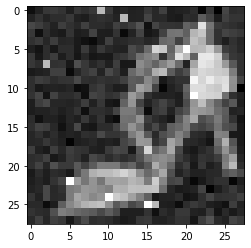

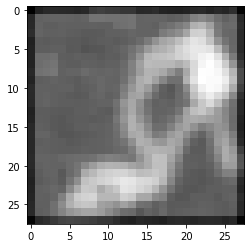

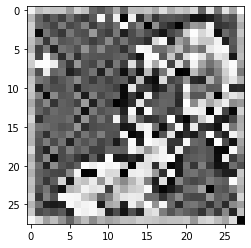

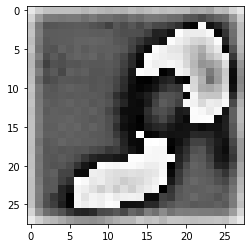

In [7]:
trial = test_images[1]
blur1 = convolve2d(trial, blur)
sharp = convolve2d(trial, sharpen)
blurry = convolve2d(sharp, blur)
viewImage(trial)
viewImage(blur1)
viewImage(sharp)
viewImage(blurry)

In [0]:
def preprocess(arr):
    # Reshape images to 28x28x1
    tmp = np.reshape(arr, (arr.shape[0], 28, 28, 1))
    
    # Normalize
    tmp = tmp / 255.0
    
    return tmp

Here's the plan: 


*   Train CNN on each of the images with different filters on them
*   Vote between 3 models



In [0]:
with open('train_labels.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    train_labels = np.array(list(reader))[1:,1]
    
labels = np.zeros((10, 10))
for i in range(10):
    labels[i, i] = 1

train_labels = np.array([labels[int(x), :] for x in train_labels])

CREATING THE TRAINING DATA: Using different training data for each model, hopefully will diversify

In [0]:
train_i = 1000

# OG
x_train = train_images[:train_i]
x_train = preprocess(x_train)

# Sharp
x_sharp_train = train_images[:train_i]
for im in x_sharp_train:
  im = convolve2d(im, sharpen)

# Blur
x_blur_train = train_images[train_i: 2* train_i]
for im in x_blur_train:
  im = convolve2d(im, blur)

# Both
x_sharp_train2 = train_images[train_i * 2: train_i * 3]
for im in x_sharp_train2:
  im = convolve2d(im, sharpen)

x_both_train = x_sharp_train2
for im in x_both_train:
  im = convolve2d(im, blur)


x_both_train = preprocess(x_both_train)
x_sharp_train = preprocess(x_sharp_train)
x_blur_train = preprocess(x_blur_train)
# Labels
y_train_sharp = train_labels[:train_i]
y_train_blur = train_labels[train_i: train_i*2]
y_train_both = train_labels[train_i *2: train_i*3]

Using Tomer's CNN model

In [11]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=5, activation='relu', 
                  input_shape=(28, 28, 1), kernel_regularizer=regularizers.l2(0.01)))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(Flatten())
model.add(Dense(units=10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=[keras.metrics.binary_accuracy])

In [0]:
model2 = keras.models.clone_model(model)
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=[keras.metrics.binary_accuracy])
model3 = keras.models.clone_model(model)
model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=[keras.metrics.binary_accuracy])
model4 = keras.models.clone_model(model)
model4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=[keras.metrics.binary_accuracy])

In [13]:
model.fit(x_sharp_train, y_train_sharp, epochs=15)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/15





1000/1000 [==============================] - 2s 2ms/step - loss: 2.6815 - binary_accuracy: 0.9000
Epoch 2/15
1000/1000 [==============================] - 2s 2ms/step - loss: 2.2711 - binary_accuracy: 0.9011
Epoch 3/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.9795 - binary_accuracy: 0.9000
Epoch 4/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6667 - binary_accuracy: 0.9104
Epoch 5/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6094 - binary_accuracy: 0.9120
Epoch 6/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7242 - binary_accuracy: 0.9078
Epoch 7/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.5943 - binary_accuracy: 0.9142
Epoch 8/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6359 - binary_accuracy: 0.9125
Epoch 9/15
1000/1000 [====

In [14]:
model2.fit(x_blur_train, y_train_blur, epochs=15)

Epoch 1/15
1000/1000 [==============================] - 2s 2ms/step - loss: 2.6279 - binary_accuracy: 0.9000
Epoch 2/15
1000/1000 [==============================] - 2s 2ms/step - loss: 2.0150 - binary_accuracy: 0.9017
Epoch 3/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7087 - binary_accuracy: 0.9089
Epoch 4/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.5841 - binary_accuracy: 0.9135
Epoch 5/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6340 - binary_accuracy: 0.9109
Epoch 6/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6345 - binary_accuracy: 0.9154
Epoch 7/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.9813 - binary_accuracy: 0.9024
Epoch 8/15
1000/1000 [==============================] - 2s 2ms/step - loss: 2.1206 - binary_accuracy: 0.9079
Epoch 9/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7087 - binary_accuracy: 0.9164
Epoch 10/15
1000/10

In [15]:
model3.fit(x_both_train, y_train_both, epochs=15)

Epoch 1/15
1000/1000 [==============================] - 2s 2ms/step - loss: 2.6403 - binary_accuracy: 0.9000
Epoch 2/15
1000/1000 [==============================] - 2s 2ms/step - loss: 2.0490 - binary_accuracy: 0.9045
Epoch 3/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7631 - binary_accuracy: 0.9082
Epoch 4/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7120 - binary_accuracy: 0.9060
Epoch 5/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.8548 - binary_accuracy: 0.9043
Epoch 6/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6046 - binary_accuracy: 0.9175
Epoch 7/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.8594 - binary_accuracy: 0.9066
Epoch 8/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.5815 - binary_accuracy: 0.9159
Epoch 9/15
1000/1000 [==============================] - 2s 2ms/step - loss: 2.0195 - binary_accuracy: 0.9051
Epoch 10/15
1000/10

In [16]:
model4.fit(x_train, y_train_sharp, epochs=15)

Epoch 1/15
1000/1000 [==============================] - 2s 2ms/step - loss: 2.6738 - binary_accuracy: 0.9000
Epoch 2/15
1000/1000 [==============================] - 2s 2ms/step - loss: 2.0752 - binary_accuracy: 0.9020
Epoch 3/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7184 - binary_accuracy: 0.9081
Epoch 4/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6136 - binary_accuracy: 0.9123
Epoch 5/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.5878 - binary_accuracy: 0.9124
Epoch 6/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.4912 - binary_accuracy: 0.9167
Epoch 7/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.4432 - binary_accuracy: 0.9179
Epoch 8/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.4407 - binary_accuracy: 0.9203
Epoch 9/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.5378 - binary_accuracy: 0.9145
Epoch 10/15
1000/10

In [0]:
def vote(w, x, y, z):
  votelist = [x, y, z, w]
  countx = votelist.count(x)
  county = votelist.count(y)
  countz = votelist.count(z)
  countw = votelist.count(w)

  countlist = [countx, county, countz, countw]
  maxcount = max(countlist)

  for i in range(len(countlist)):
    if countlist[i] == maxcount:
      return votelist[i]

In [0]:
test_ready = preprocess(test_images)

In [0]:
classes1 = model.predict(test_ready)
classes2 = model2.predict(test_ready)
classes3 = model3.predict(test_ready)
classes4 = model4.predict(test_ready)

In [0]:
classes1 = classes1.argmax(axis=1)
classes2 = classes2.argmax(axis=1)
classes3 = classes3.argmax(axis=1)
classes4 = classes4.argmax(axis=1)

In [0]:
finalpred = classes1
for i in range(len(classes1)):
  w = classes4[i]
  x = classes1[i]
  y = classes2[i]
  z = classes3[i]
  finalpred[i] = vote(x, y, z, w)

In [46]:
count = 0
with open('submission_sharp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['ID', 'label'])
    for idx, val in enumerate(classes1):
        writer.writerow([str(idx), str(val)])
        count += 1
        
print(count)

20000


In [47]:
count = 0
with open('submission_blur.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['ID', 'label'])
    for idx, val in enumerate(classes2):
        writer.writerow([str(idx), str(val)])
        count += 1
        
print(count)

20000


In [48]:
count = 0
with open('submission_both.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['ID', 'label'])
    for idx, val in enumerate(classes3):
        writer.writerow([str(idx), str(val)])
        count += 1
        
print(count)

20000


In [49]:
count = 0
with open('submission_all.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['ID', 'label'])
    for idx, val in enumerate(finalpred):
        writer.writerow([str(idx), str(val)])
        count += 1
        
print(count)

20000


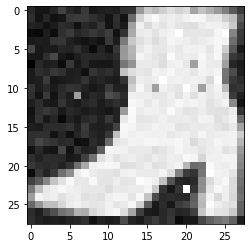

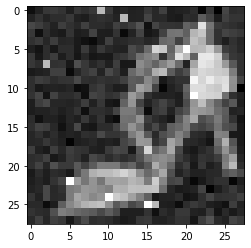

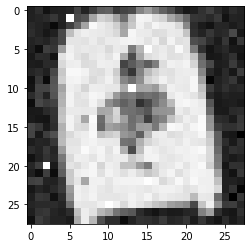

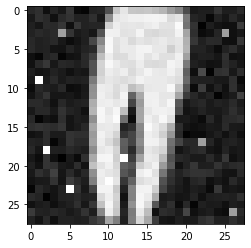

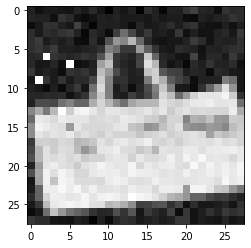

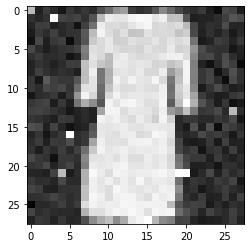

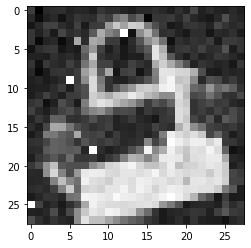

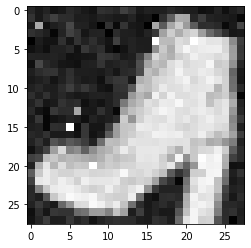

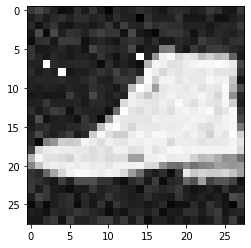

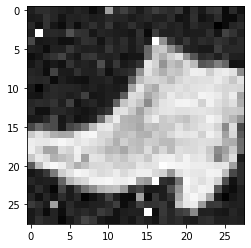

In [50]:
viewImages(test_images[:10])